### Objective

1. Introduce the concept of SSL
2. Compare the performance on CIFAR10 dataset:
    - CNN on small labelled dataset
    - CNN on small labelled dataset + augmentation
    - CNN on small labelled dataset + SSL on large unlabelled dataset
    - CNN on small labelled dataset + SSL on large unlabelled dataset + augmentation

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [91]:
# Download the dataset
transform = transforms.Compose(
    [transforms.ToTensor()])

data_path = os.path.expanduser('~/.cache/torch/')

trainset = torchvision.datasets.CIFAR10(root=data_path, train=True, download=True, transform=transform)


Files already downloaded and verified


In [92]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/nipun.batra/.cache/torch/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [93]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

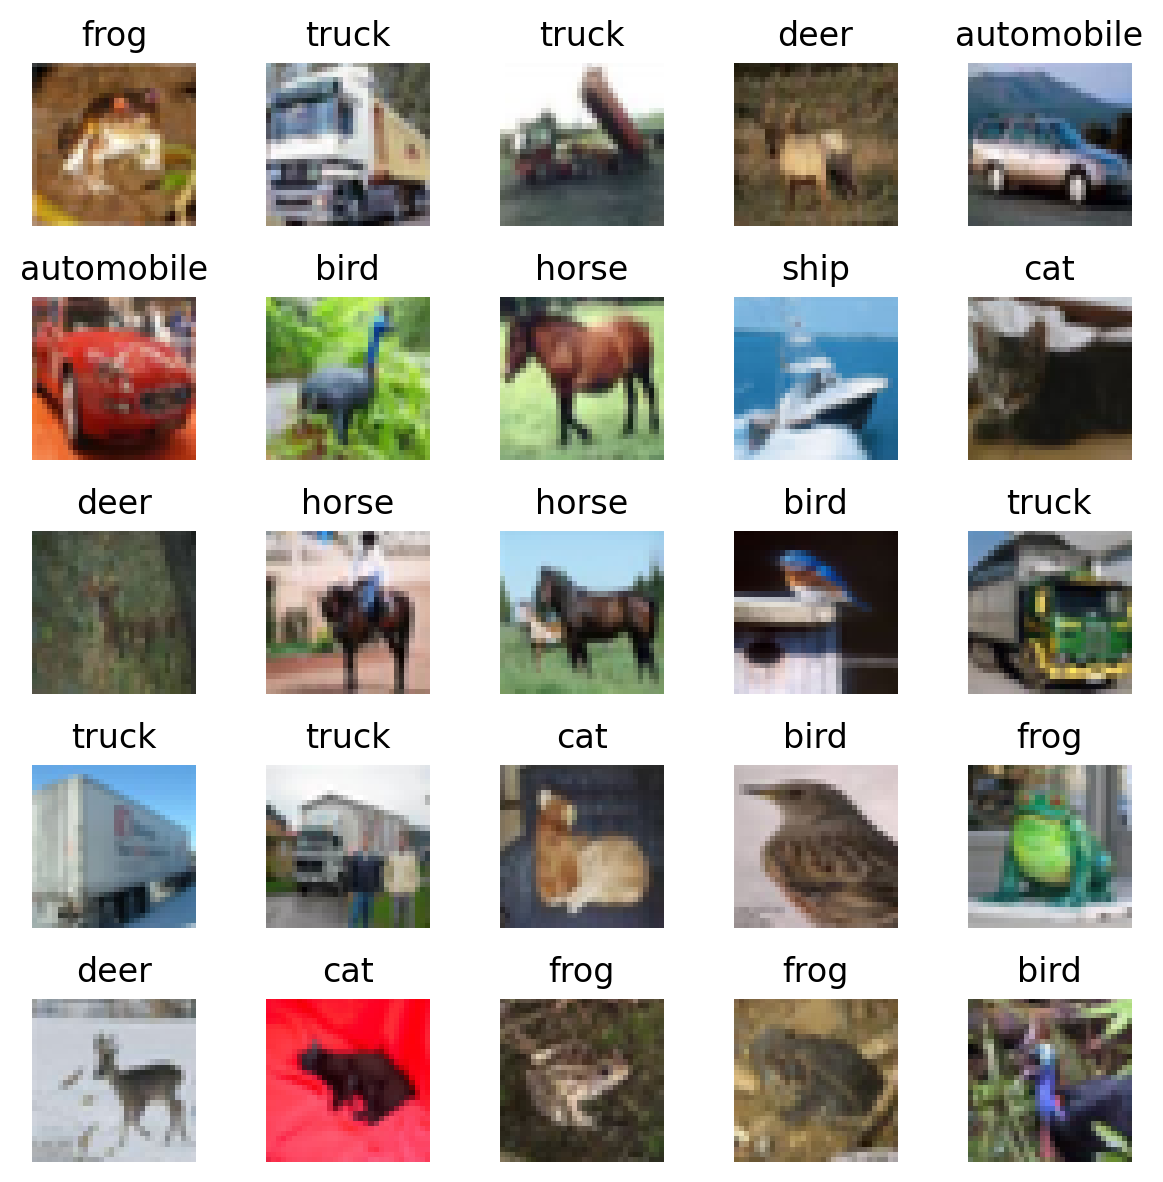

In [94]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(trainset.data[i])
    plt.axis('off')
    plt.title(trainset.classes[trainset.targets[i]])
plt.tight_layout()
    
    

In [95]:
# Create a trainset containing only the first 100 images and test set is everything else

X_train = trainset.data[:100]
y_train = trainset.targets[:100]

X_test = trainset.data[100:]
y_test = trainset.targets[100:]

# Convert to tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.tensor(y_train)

X_test = torch.from_numpy(X_test).float()
y_test = torch.tensor(y_test)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# But, CNNs expect n_channels x height x width
# So, we need to transpose the data

X_train = X_train.transpose(1, 3)
X_test = X_test.transpose(1, 3)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)



torch.Size([100, 32, 32, 3]) torch.Size([100]) torch.Size([49900, 32, 32, 3]) torch.Size([49900])
torch.Size([100, 3, 32, 32]) torch.Size([100]) torch.Size([49900, 3, 32, 32]) torch.Size([49900])


In [96]:
# Simple CNN model 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

import torch.nn as nn
import torch.nn.functional as F

class Featurizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2) # 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, 5) # 6 input channels, 16 output channels, 5x5 kernel

    def forward(self, x):
        x = self.pool(F.gelu(self.conv1(x))) # conv1 -> relu -> pool
        x = self.pool(F.gelu(self.conv2(x))) # conv2 -> relu -> pool
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        return x

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # 16 * 5 * 5 input features, 120 output features
        self.fc2 = nn.Linear(120, 84) # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 10) # 84 input features, 10 output features

    def forward(self, x):
        x = F.gelu(self.fc1(x)) # fc1 -> relu
        x = F.gelu(self.fc2(x)) # fc2 -> relu
        x = self.fc3(x) # fc3
        return x

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.featurizer = Featurizer()
        self.classifier = Classifier()

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x


In [97]:
net = Net().to(device)

In [98]:
net

Net(
  (featurizer): Featurizer(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=400, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [99]:
net(X_train.to(device)).shape

torch.Size([100, 10])

In [100]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)

In [101]:
from astra.torch.utils import train_fn

res_dict= train_fn(net, X_train, y_train, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=500)

Loss: 0.000284: 100%|██████████| 500/500 [00:03<00:00, 166.28it/s]


Text(0, 0.5, 'Loss')

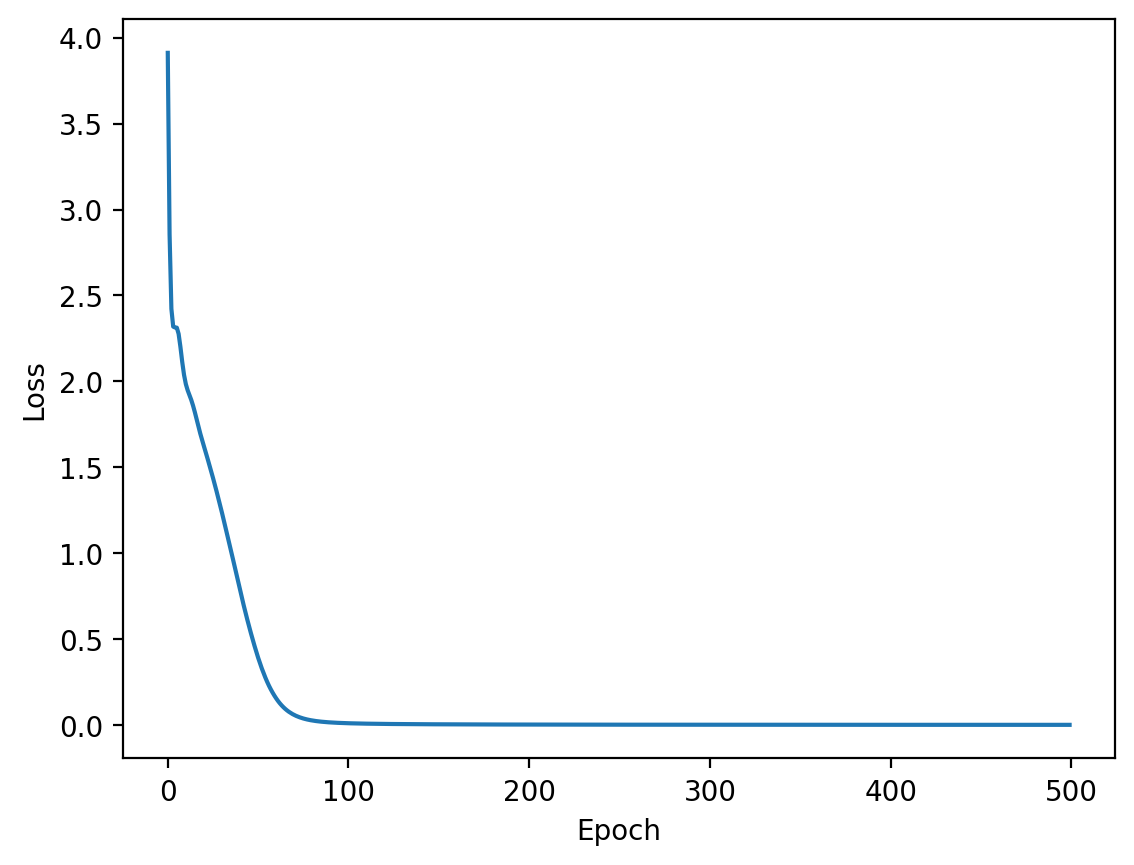

In [102]:
plt.plot(res_dict['epoch_losses'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [103]:
def predict(net):
    with torch.no_grad():
        logits_pred = net(X_test)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y_test).float().mean()
        print(f'Accuracy: {acc:.2%}')
    cm = confusion_matrix(y_test.cpu(), y_pred.cpu())

    ConfusionMatrixDisplay(cm, display_labels=trainset.classes).plot(values_format='d'
                                                                , cmap='Blues')

    # Rotate the labels on x-axis to make them readable
    _ = plt.xticks(rotation=90)
    

Accuracy: 19.46%


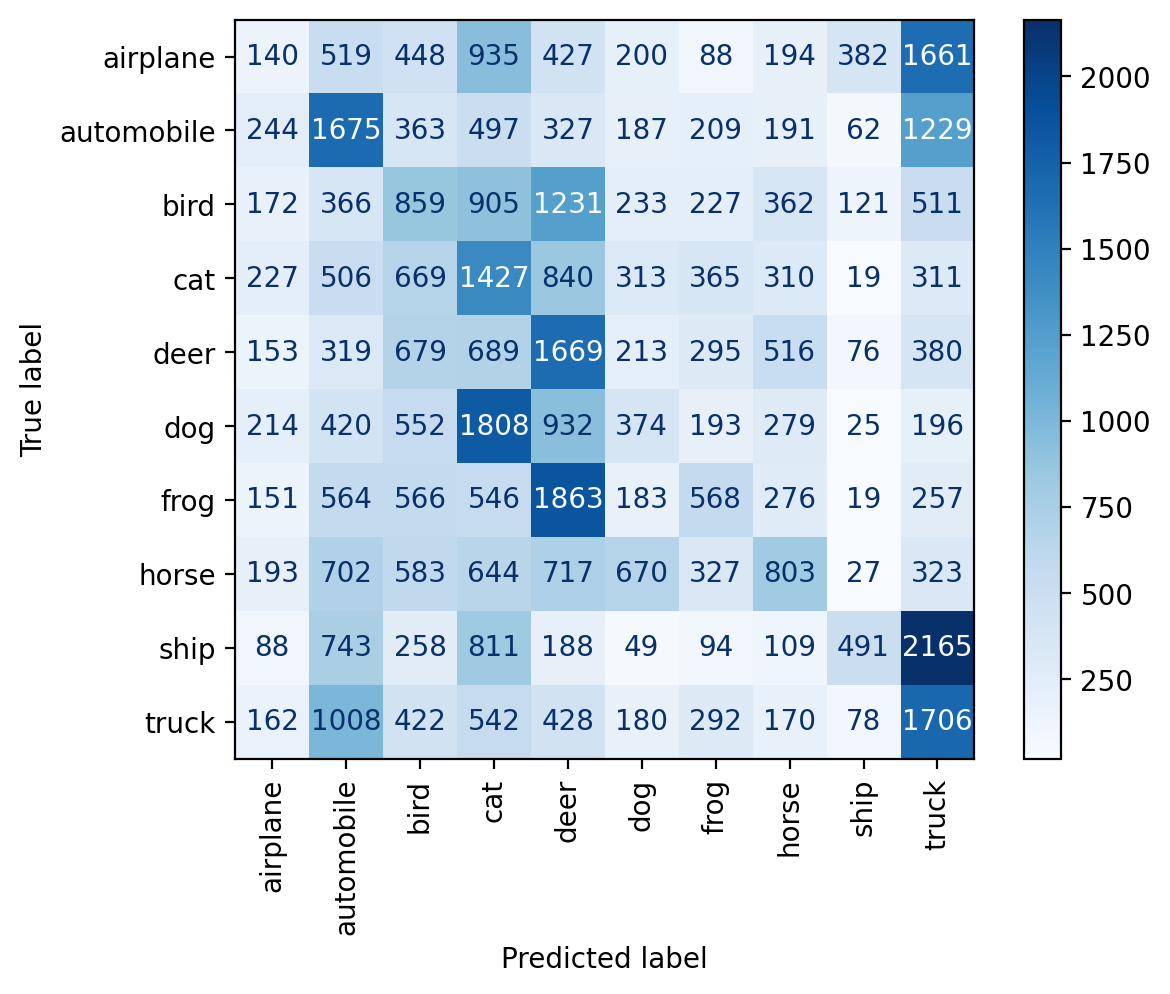

In [104]:
predict(net)

In [105]:
# Define data augmentation transformations
augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(2),
    transforms.RandomVerticalFlip(),
])

In [106]:
def plot_orginal_and_augmented_images(image_id):
    # Function to plot images in one row
    def plot_images(images, titles):
        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        for i in range(len(images)):
            axes[i].imshow(images[i])
            axes[i].set_title(titles[i])
            axes[i].axis('off')
        plt.show()

    # Select the original image and create augmented images
    original_image = X_train[image_id].permute(1, 2, 0).cpu().numpy() / 255

    # Create a list to store augmented images
    augmented_images = [original_image]
    augmented_titles = ["Original Image"]

    # Apply augmentations and add the transformed images to the list
    for _ in range(5):
        transformed_image = augmentation(X_train[image_id]).permute(1, 2, 0).cpu().numpy() / 255
        augmented_images.append(transformed_image)
        augmented_titles.append("Augmented Image")

    # Plot the original image and augmented images in one row
    plot_images(augmented_images, augmented_titles)


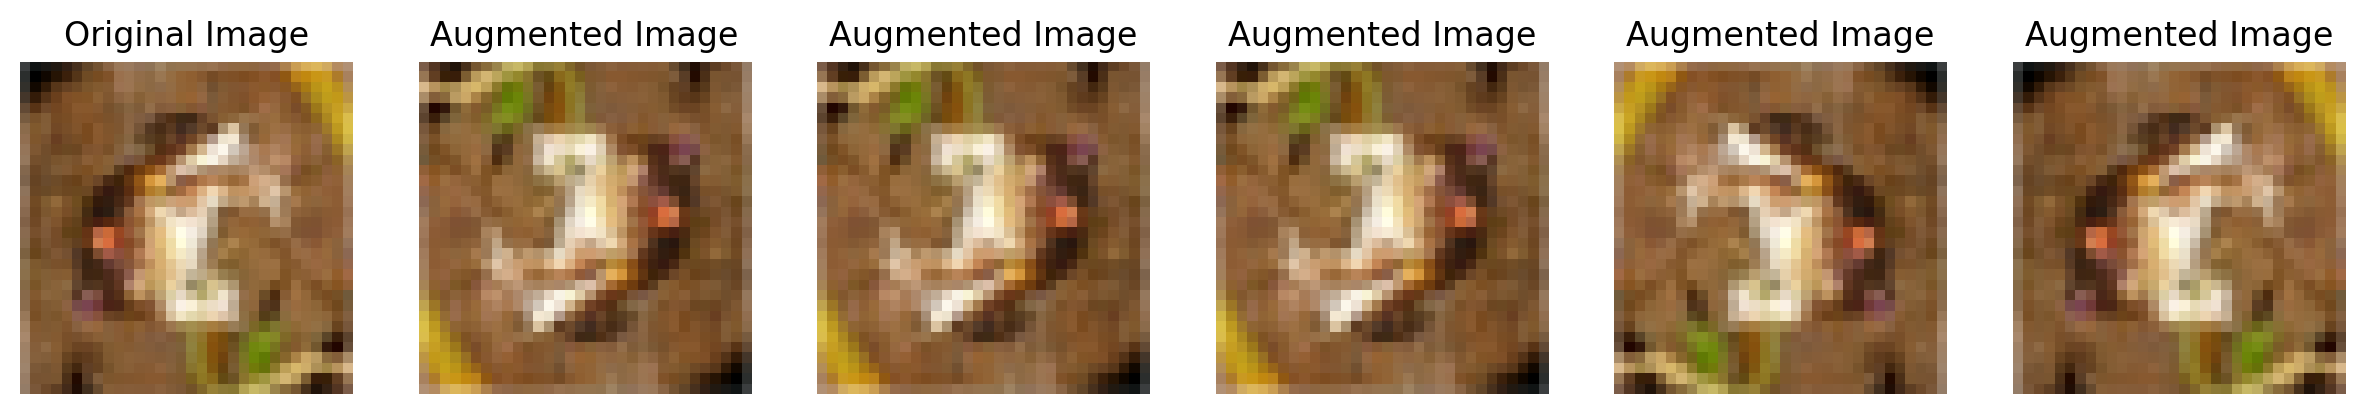

In [107]:
plot_orginal_and_augmented_images(0)

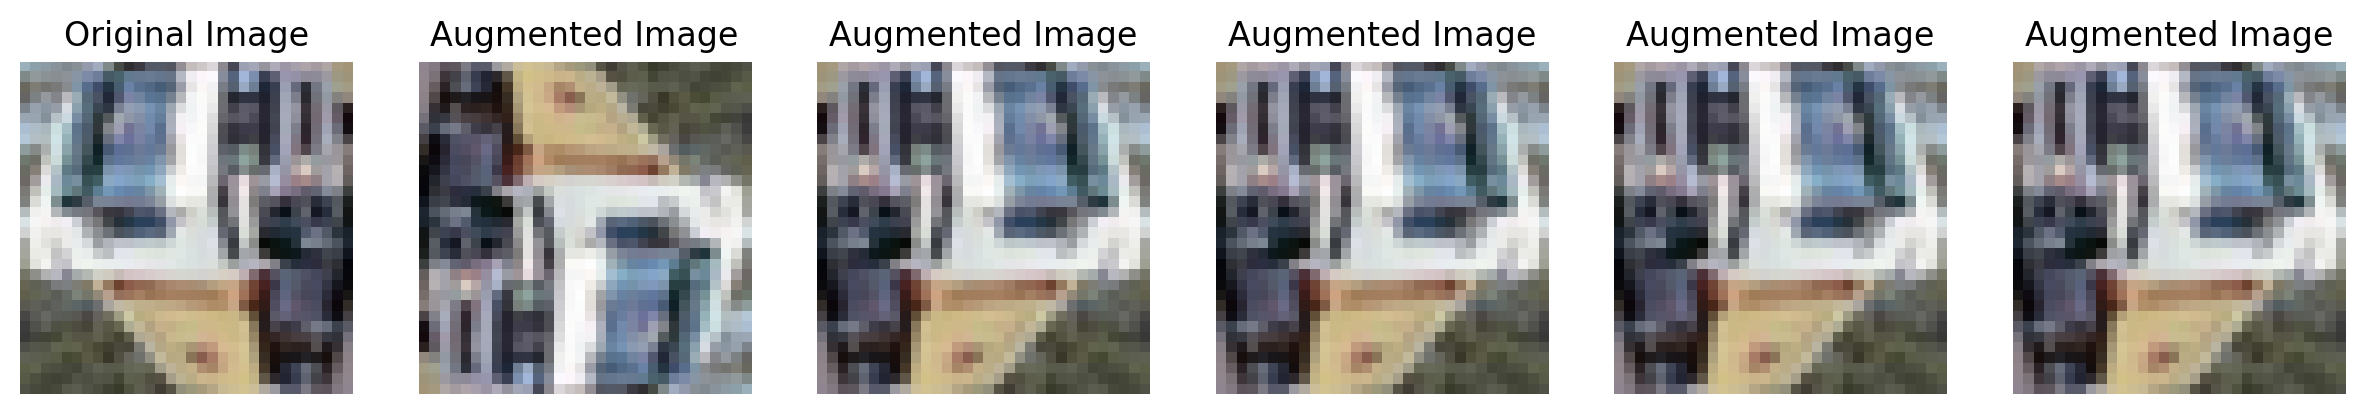

In [108]:
plot_orginal_and_augmented_images(1)

In [109]:
# Create augmented dataset with 5 augmented images per original image

X_augmented = []
y_augmented = []

# Number of augmented images per original image
num_augmentations = 10

for i in range(len(X_train)):
    for _ in range(num_augmentations):
        augmented_image = augmentation(X_train[i]).permute(1, 2, 0).cpu().numpy() 
        X_augmented.append(augmented_image)
        y_augmented.append(y_train[i].cpu())

X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)
# Convert the lists to tensors
X_augmented = torch.from_numpy(X_augmented).float()
y_augmented = torch.tensor(y_augmented)

print(X_augmented.shape, y_augmented.shape)
    

torch.Size([1000, 32, 32, 3]) torch.Size([1000])


In [110]:
X_train.shape, y_train.shape

(torch.Size([100, 3, 32, 32]), torch.Size([100]))

In [111]:
# Get X_augmented and y_augmented to the device and in correct shape
X_augmented = X_augmented.to(device).transpose(1, 3)
y_augmented = y_augmented.to(device)

print(X_augmented.shape, y_augmented.shape)

torch.Size([1000, 3, 32, 32]) torch.Size([1000])


In [112]:
# Stack the original and augmented data
X_train_augmented = torch.cat([X_train, X_augmented])
y_train_augmented = torch.cat([y_train, y_augmented])

print(X_train_augmented.shape, y_train_augmented.shape)

torch.Size([1100, 3, 32, 32]) torch.Size([1100])


In [113]:
net = Net().to(device)
res_dict = train_fn(net, X_train_augmented, y_train_augmented, nn.CrossEntropyLoss(), lr=3e-4, n_epochs=500)

Loss: 0.000425: 100%|██████████| 500/500 [00:08<00:00, 61.50it/s]


Accuracy: 18.69%


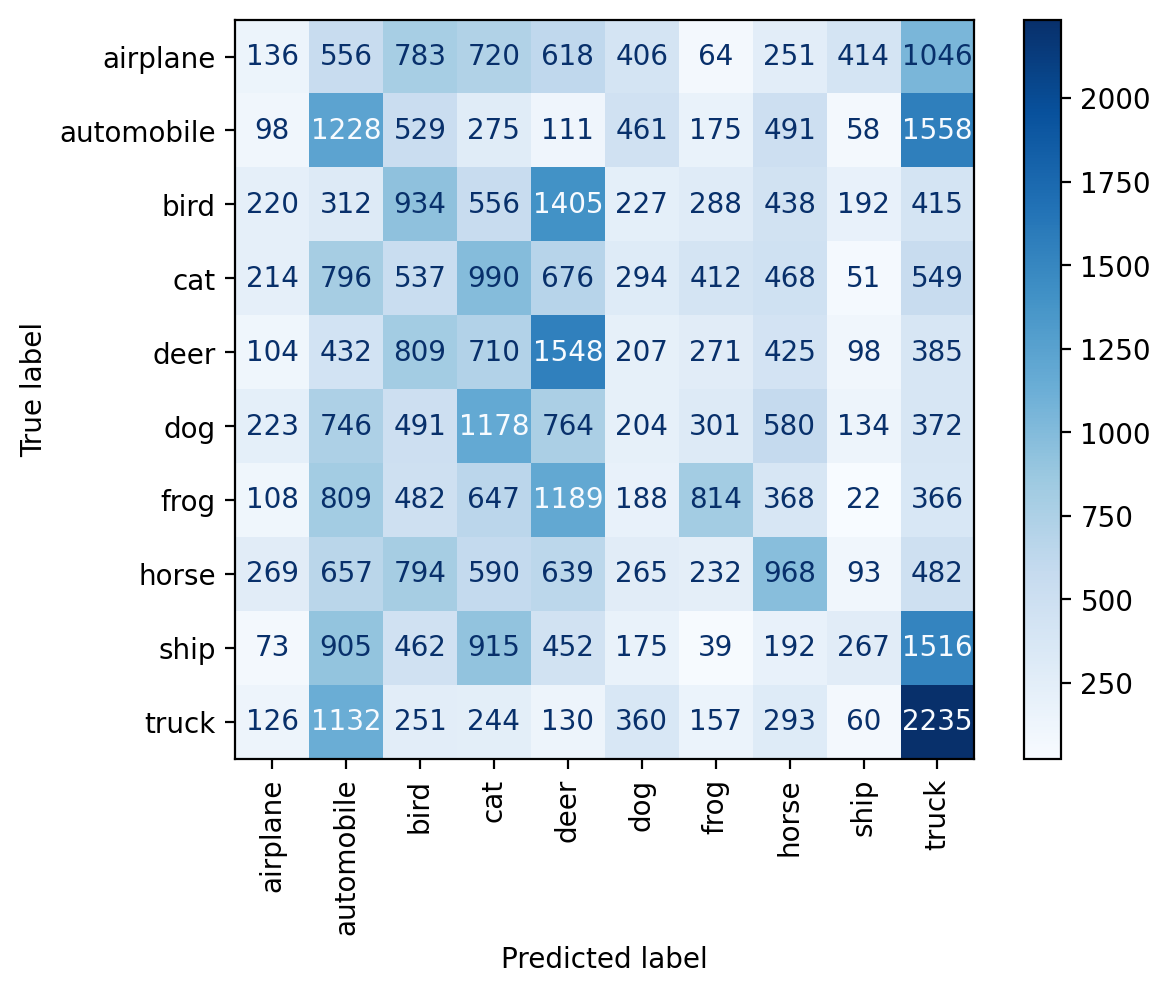

In [114]:
predict(net)

In [115]:
import pandas as pd
pd.DataFrame(X_train[0][0].cpu()).describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.00000,...,32.000000,32.000000,32.00000,32.000000,32.00000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,130.187500,106.625000,112.687500,115.843750,111.562500,102.593750,106.59375,116.125000,116.156250,118.43750,...,148.125000,145.781250,149.09375,149.437500,149.81250,145.906250,142.468750,141.312500,141.343750,160.250000
std,32.161324,35.030632,29.622831,24.588366,22.564514,26.032064,26.45978,35.285702,38.661568,28.01375,...,24.739613,31.960394,34.28849,21.470066,22.70347,27.527534,34.912781,37.874527,38.779449,32.852554
min,43.000000,0.000000,16.000000,33.000000,50.000000,32.000000,58.00000,41.000000,44.000000,62.00000,...,108.000000,84.000000,77.00000,121.000000,117.00000,71.000000,33.000000,50.000000,34.000000,92.000000
25%,128.000000,105.750000,111.500000,112.000000,105.250000,88.000000,86.75000,101.750000,83.750000,99.75000,...,134.750000,135.750000,131.25000,135.000000,133.50000,134.000000,127.000000,135.000000,128.750000,143.000000
50%,139.000000,119.500000,121.500000,121.500000,119.500000,107.000000,109.50000,124.000000,126.000000,127.50000,...,144.500000,148.000000,149.50000,141.000000,149.00000,142.500000,142.000000,143.000000,141.000000,161.500000
75%,149.000000,126.250000,129.250000,130.250000,125.500000,120.500000,127.50000,134.250000,132.500000,136.00000,...,151.500000,159.250000,168.25000,163.750000,154.25000,149.000000,153.250000,156.000000,173.000000,177.500000
max,168.000000,133.000000,142.000000,146.000000,141.000000,140.000000,151.00000,209.000000,217.000000,156.00000,...,205.000000,212.000000,224.00000,211.000000,215.00000,216.000000,220.000000,208.000000,201.000000,218.000000


In [116]:
pd.DataFrame(X_augmented[0][0].cpu()).describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,...,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,118.937500,124.937500,137.062500,131.468750,120.656250,126.000000,139.718750,149.093750,147.375000,148.343750,...,154.687500,149.000000,141.031250,132.406250,130.093750,135.718750,136.625000,132.343750,127.687500,135.500000
std,40.272408,36.917465,35.723797,25.206226,24.280098,19.319054,15.771011,43.811443,50.999527,44.272331,...,40.638008,40.577286,38.228924,35.820213,31.799126,23.998972,30.011557,38.824345,49.983505,53.032555
min,32.000000,35.000000,67.000000,88.000000,34.000000,58.000000,104.000000,84.000000,75.000000,74.000000,...,101.000000,84.000000,81.000000,66.000000,63.000000,88.000000,51.000000,18.000000,0.000000,16.000000
25%,100.000000,116.250000,118.750000,117.500000,113.750000,123.250000,130.750000,123.500000,118.750000,122.250000,...,124.250000,119.000000,117.750000,116.250000,120.750000,123.750000,128.000000,126.750000,118.500000,131.500000
50%,129.000000,127.000000,132.500000,131.000000,126.000000,130.000000,137.000000,139.000000,135.000000,137.500000,...,138.500000,141.500000,136.500000,129.500000,129.000000,132.500000,139.500000,138.500000,136.500000,145.000000
75%,136.500000,139.000000,148.250000,137.250000,133.250000,135.250000,151.250000,155.750000,159.000000,181.500000,...,182.000000,170.500000,155.250000,147.250000,140.500000,136.500000,147.250000,148.000000,154.000000,155.000000
max,199.000000,211.000000,216.000000,203.000000,159.000000,168.000000,166.000000,241.000000,250.000000,240.000000,...,248.000000,252.000000,244.000000,219.000000,218.000000,202.000000,194.000000,198.000000,201.000000,220.000000
